In [366]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import trackpy


from pathlib import Path
%matplotlib inline

In [2]:
data_dir = Path('/home/ecohen/varian-challenge/data/preproc')

Xs, ys = [], []
for filename in os.listdir(data_dir):
    data = np.load(data_dir / filename)
    X, y = data['X'], data['Y']
    if X.shape[0] > 89 or X.shape[1] < 512:
        continue
    Xs.append(X)
    ys.append(y)
    
X_train = np.stack(Xs[:-1], axis=0).reshape(-1, 512, 512)
y_train = np.stack(ys[:-1], axis=0).reshape(-1, 512, 512)
train_data = list(zip(X_train, y_train))

X_valid = Xs[-1]
y_valid = ys[-1]
valid_data = list(zip(X_valid, y_valid))

In [6]:
tumors_inds = []
for index, img in enumerate(y_train):
    if y_train[index].sum() > 0:
        tumors_inds.append(index)

In [251]:
len(tumors_inds)

54

In [504]:
cur_ind = 14

In [507]:
def perform_cv2(test):
    cur_img_norm = test/test.max()
    thresholded = cur_img_norm > np.mean(cur_img_norm)*np.pi
    thresholded = cv2.erode(thresholded.astype(np.uint16), (30, 30), iterations=10)
    thresholded = cv2.GaussianBlur(thresholded, (31, 31), 1)
    thresholded = cv2.morphologyEx(thresholded.astype(np.uint8), cv2.MORPH_OPEN, (30, 30), iterations=10)
    thresholded = cv2.GaussianBlur(thresholded, (11, 11), 10)
    return thresholded

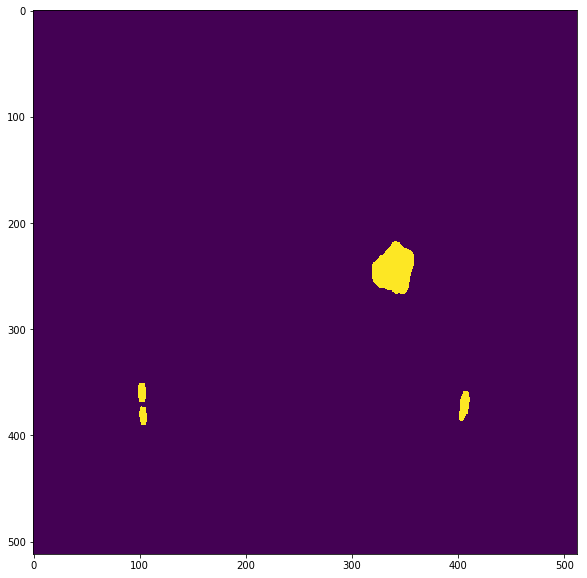

In [505]:
plt.figure(figsize=(10, 10))
cur_img = X_train[tumors_inds[cur_ind]].astype(np.uint16)

plt.imshow(thresholded)
# plt.colorbar()

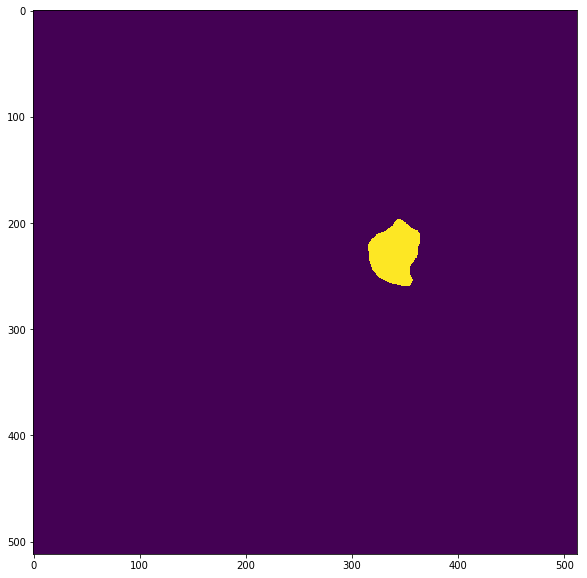

In [506]:
plt.figure(figsize=(10, 10))
plt.imshow(y_train[tumors_inds[cur_ind]])

In [382]:
X_train[tumors_inds[cur_ind]].astype(np.uint16).max(), X_train[tumors_inds[cur_ind]].astype(np.uint16).min()

(22776, 0)

In [358]:
test.dtype.astype

dtype('float64')

In [362]:
circles = cv2.HoughCircles(test,cv2.HOUGH_GRADIENT,1,10,param1=50,param2=30,minRadius=0,maxRadius=25)

In [364]:
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(test,(i[0],i[1]),i[2],(0,255,0),2)

In [360]:
test = X_train[tumors_inds[cur_ind]].astype(np.uint16)
test = change_cont(test)
vert = cv2.Sobel(test, cv2.CV_64F, 1, 0, ksize=5)
hor = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
test = np.sqrt(np.power(vert, 2) + np.power(hor, 2))
test = cv2.convertScaleAbs(test, alpha=(255.0/65535.0))

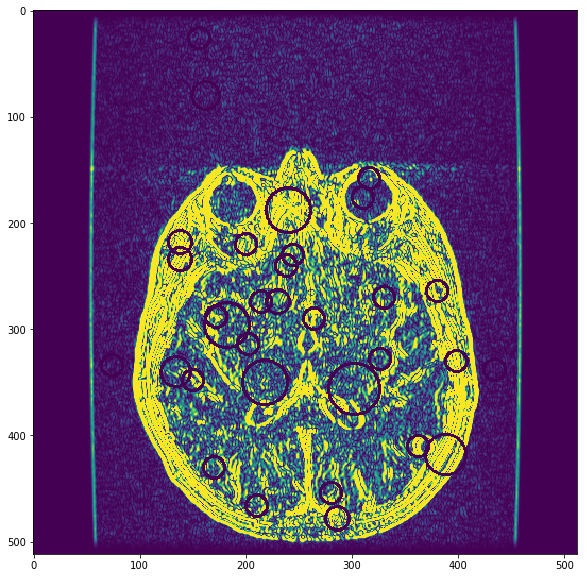

In [365]:
plt.figure(figsize=(10, 10))
plt.imshow(test)

In [300]:
def change_cont(test):
    b = 67
    c = 100
    test = cv2.addWeighted(test, 1. + c/127., test, 0, b-c)
    return test

In [324]:
def perform_cv(test):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    test = clahe.apply(test)
    test = cv2.convertScaleAbs(test, alpha=(255.0/65535.0))
    print(np.max(test), np.min(test))
    test = cv2.morphologyEx(test, cv2.MORPH_OPEN, (3, 3), iterations=10)
    test = change_cont(test)
#     test = cv2.equalizeHist(test)
    test = cv2.fastNlMeansDenoisingColored(np.dstack((test, test, test)),None,10,10,7,21)[:,:,0]
    test = cv2.GaussianBlur(test, (7, 7), 1)
    test = cv2.dilate(test, (5, 5), iterations=10)
#     test = cv2.adaptiveThreshold(test, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
#             cv2.THRESH_BINARY, 3, 2)
#     test = cv2.adaptiveThreshold(test,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY ,41,3)
    return test

208 0


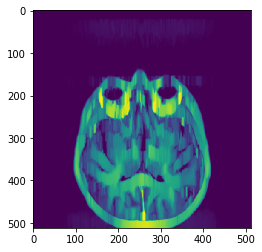

In [329]:
plt.imshow(perform_cv(X_train[tumors_inds[cur_ind]].astype(np.uint16)))

In [697]:
def filter_components(test):
    ret, thresh = cv2.threshold(test,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    num_labels = output[0]
    label_map = output[1]
    label_stats = output[2]
    label_width = label_stats[:, cv2.CC_STAT_WIDTH]
    label_height = label_stats[:, cv2.CC_STAT_HEIGHT]
    label_area = label_stats[:, cv2.CC_STAT_AREA]
    ratio = label_width / label_height
    
    bad_inds = []
    for index in range(num_labels):
        label_area_percentage = label_area[index] / (label_map.shape[0] * label_map.shape[1])
        if label_area_percentage >= 0.01 or label_area_percentage <= 0.0002:
            bad_inds.append(index)
            continue
        if ratio[index] >= 1.3 or ratio[index] <= 0.7:
            bad_inds.append(index)
            continue
    
    for bad_ind in bad_inds:
        label_map[label_map == bad_ind] = 0
        
    label_map = cv2.dilate(label_map.astype(np.uint8), (3, 4), iterations=10)
    label_map[100:150, 250:275] = 0
    label_map[400:470, 250:275] = 0
        
    return label_map

In [734]:
cur_ind = 12

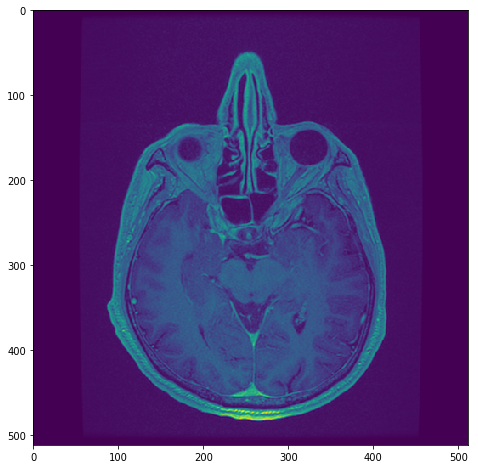

In [732]:
plt.figure(figsize=(8, 8))
plt.imshow(X_train[tumors_inds[cur_ind]].astype(np.uint16))

In [ ]:
img = np.array(norm * 255, dtype=np.uint8)

test = cv2.GaussianBlur(np.array((img > 75) & (img < 110), dtype=np.uint8) * 255, (3, 3), 1)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(X_train[tumors_inds[cur_ind]])

ax = fig.add_subplot(1, 3, 2)
predicted = cv2.filter2D(test, 6, canvas)
ax.imshow(get_heatmap(X_train[tumors_inds[cur_ind]]))
    
ax = fig.add_subplot(1, 3, 3)
ax.imshow(y_train[tumors_inds[cur_ind]])

cur_ind += 1

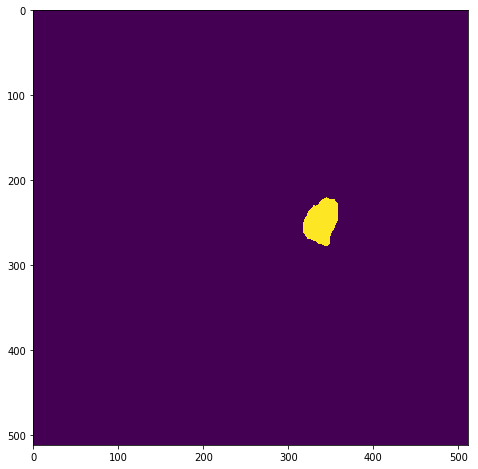

In [738]:
test = perform_cv2(X_train[tumors_inds[cur_ind]].astype(np.uint16))
processed_label_map = filter_components(test)
plt.figure(figsize=(8, 8))
plt.imshow(processed_label_map);

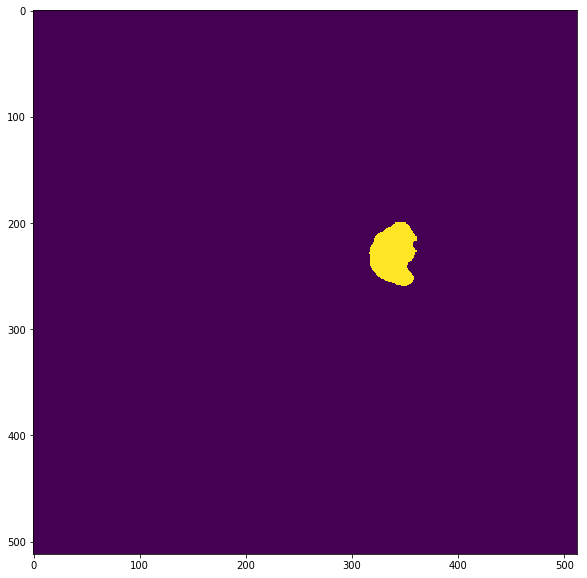

In [739]:
plt.figure(figsize=(10, 10))
plt.imshow(y_train[tumors_inds[cur_ind]]);

In [740]:
cur_ind += 1